In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import xgboost
import random
from datetime import datetime
from random import random
from pandas_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KDTree
from datetime import datetime
from pulp import *
from decimal import Decimal
from scipy.optimize import minimize

In [3]:
df_history = pd.read_csv('./data/Demand_History.csv')
df = pd.read_csv('./data/exisiting_EV_infrastructure_2018.csv')


In [217]:
df

,supply_point_index,x_coordinate,y_coordinate,total_parking_slots,existing_num_SCS,existing_num_FCS
0,0,50.163110,19.412014,23,5,3
1,1,37.336451,58.119225,27,4,7
2,2,46.709232,57.525650,31,6,14
3,3,30.528626,55.379835,26,5,5
4,4,51.521781,35.116755,32,11,6
...,...,...,...,...,...,...
95,95,45.471204,20.999414,24,3,4
96,96,30.318396,33.388335,32,5,10
97,97,36.218839,22.235766,32,4,14
98,98,42.936915,38.122442,28,7,5


In [22]:
df_history['2018'].sum()

361529.6365968907

In [24]:
df['existing_num_FCS'].sum()*400 + df.existing_num_SCS.sum()*200

361600

In [8]:
df_history

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563
...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574


In [31]:
regr = LinearRegression()

In [193]:
df_pred = df_history



# Predict Demand for 2019 and 2020

In [1129]:
df_pred = df_history
#Lineare Regression
X =np.array([2012,2013,2014,2015,2016,2017,2018])
pred_2019 = []
pred_2020 = []
for row,cols in df_history.iterrows():
    y = []
    for num,(i) in enumerate(X):
        y.append(df_history[str(i)][row])  
    regr.fit(X.reshape(-1, 1), y)
    pred_2019.append(float(regr.predict(np.array([2019]).reshape(-1, 1))))
    pred_2020.append(float(regr.predict(np.array([2020]).reshape(-1, 1))))
df_pred['2019'] = pred_2019
df_pred['2020'] = pred_2020
df_pred

,Unnamed: 0,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,14.700858,16.699641
1,1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,14.342703,16.310750
2,2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,14.876648,16.982585
3,3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,16.735146,19.149632
4,4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,17.209426,19.669637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,5.841534,6.615759
4092,4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,2.095118,2.379986
4093,4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,3.404481,3.852547
4094,4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,7.488203,8.501453


In [5]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression(),
)

In [267]:
df_pred = df_history

#Polynomal Regression
X =np.array([2012,2013,2014,2015,2016,2017,2018])
pred_2019 = []
pred_2020 = []
for row,cols in df_history.iterrows():
    y = []
    for num,(i) in enumerate(X):
        y.append(df_history[str(i)][row])  
    polynomial_regression.fit(X.reshape(-1, 1), y)
    pred_2019.append(float(polynomial_regression.predict(np.array([2019]).reshape(-1, 1))))
    pred_2020.append(float(polynomial_regression.predict(np.array([2020]).reshape(-1, 1))))
df_pred['2019'] = pred_2019
df_pred['2020'] = pred_2020
df_pred

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,15.524397,18.140834
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,14.711820,16.956706
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,17.332947,21.281108
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,19.205706,23.473113
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,20.119375,24.762049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,6.451971,7.684023
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,2.322019,2.777063
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,3.657420,4.295191
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,7.851528,9.137271


In [1337]:
df_pred.to_csv('./data/df_pred_pol_neu.csv', index=False)

# Helper DataFrames

# Calculate Closest Supplypoint for each Supplypoint, add Demand Forecast and Difference compared to Previous year

In [5]:
#df_closest_supply = df_history['demand_point_index']
df_pred = pd.read_csv('./data/df_pred_pol_neu.csv')
X = np.array(df[['x_coordinate','y_coordinate']])
supply_id = []
supply_distance = []
tree = KDTree(X, leaf_size=2) 
for i in range(len(df_history)):           
    dist, ind = tree.query(np.array(df_history[['x_coordinate','y_coordinate']].iloc[i]).reshape(1, -1), k=100) 
    #print(f'Nearest Suppply: {ind}, Distance: {dist}')
    supply_id.append(ind[0])
    supply_distance.append(dist[0])
df_closest_supply = pd.DataFrame({'demand_point_index':df_history['demand_point_index'],'closest_supply_index':supply_id,'supply_distance':supply_distance,'Forecasted_Demand_2019':df_pred['2019'],'Rising_Demand_2019': df_pred['2019']-df_pred['2018'],'Forecasted_Demand_2020':df_pred['2020'],'Rising_Demand_2020': df_pred['2020']-df_pred['2019']})
#df_closest_supply['supply_distance'] = pd.DataFrame(supply_distance)
df_closest_supply

,demand_point_index,closest_supply_index,supply_distance,Forecasted_Demand_2019,Rising_Demand_2019,Forecasted_Demand_2020,Rising_Demand_2020
0,0,"[38, 88, 24, 57, 99, 60, 66, 34, 90, 74, 37, 6...","[8.004580252301615, 8.519681182197928, 14.0635...",18.629276,5.509704,23.583084,4.953808
1,1,"[38, 88, 24, 57, 99, 60, 66, 34, 74, 90, 37, 6...","[7.010519044978748, 8.628750195129735, 13.0756...",17.654184,5.634093,22.043718,4.389533
2,2,"[38, 88, 24, 57, 99, 60, 66, 74, 34, 90, 37, 6...","[6.018425836087249, 8.85018036051274, 12.08966...",20.799537,6.781283,27.665441,6.865904
3,3,"[38, 88, 24, 57, 99, 60, 66, 74, 90, 34, 37, 6...","[5.029465360150645, 9.175840827807518, 11.1062...",23.046847,8.034545,30.515047,7.468200
4,4,"[38, 88, 24, 57, 99, 60, 66, 74, 90, 34, 37, 6...","[4.045935500403834, 9.595124667293973, 10.1260...",24.143251,7.787687,32.190664,8.047413
...,...,...,...,...,...,...,...
4091,4091,"[16, 21, 2, 63, 47, 22, 81, 89, 72, 33, 43, 53...","[12.139734712501868, 13.368589677467302, 14.11...",7.742365,2.316172,9.989230,2.246865
4092,4092,"[16, 21, 2, 63, 47, 22, 81, 89, 72, 33, 43, 53...","[12.882291834070493, 14.083531845253647, 15.02...",2.786423,0.728973,3.610181,0.823759
4093,4093,"[16, 21, 2, 63, 47, 81, 89, 22, 72, 33, 43, 53...","[13.657735057702498, 14.831471555717654, 15.95...",4.388904,1.170385,5.583748,1.194844
4094,4094,"[16, 21, 2, 63, 47, 81, 89, 22, 33, 72, 43, 53...","[14.46077490712833, 15.607665673631342, 16.883...",9.421834,3.159260,11.878452,2.456619


# Demand to supply Distance DF

In [210]:
supply = []
distance = []
demand = []
counter = 0
for i, row in df_closest_supply.iterrows():

    for j in range(100):
        supply.append(int(row.closest_supply_index[j]))
        distance.append(float(row.supply_distance[j]))
        demand.append(int(i))
        counter +=1
df_distance_demand_supply = pd.DataFrame({'Demand_Index': demand, 'Supply_Index':supply, 'Distance':distance})
supply = []
distance = []
demand = []
for i in range(4096):
    print(i)
    for j in range(100):
        demand.append(i)
        supply.append(j)
        distance.append(float(df_distance_demand_supply[(df_distance_demand_supply['Demand_Index'] == i) & (df_distance_demand_supply['Supply_Index'] == j)]['Distance']))
df_distance_demand_supply = pd.DataFrame({'Demand_Index': demand, 'Supply_Index':supply, 'Distance':distance})        
     

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [211]:
df_distance_demand_supply      
 

,Demand_Index,Supply_Index,Distance
0,0,0,53.142156
1,0,1,68.387858
2,0,2,73.397670
3,0,3,62.558091
4,0,4,61.656645
...,...,...,...
409595,4095,95,46.166409
409596,4095,96,44.807714
409597,4095,97,49.467149
409598,4095,98,32.662837


In [444]:
df_distance_demand_supply[(df_distance_demand_supply['Demand_Index'] == 0) & (df_distance_demand_supply['Supply_Index'] == 0)].Distance




47    53.142156
Name: Distance, dtype: float64

In [208]:
temp_df = pd.read_csv('./Output/Highscore_tests/supply_charger_2019.csv')
temp_supply_2019 = [int(row['Supply_SCS']*200 + row['Supply_FCS']*400) for i, row in temp_df.iterrows()]
df_supply_2019 = pd.DataFrame({'Supply_id':[i for i in range(100)], 'Capacity':temp_supply_2019 })
temp_df = pd.read_csv('./Output/Highscore_tests/supply_charger_2020.csv')
temp_supply_2020 = [int(row['Supply_SCS']*200 + row['Supply_FCS']*400) for i, row in temp_df.iterrows()]
df_supply_2020 = pd.DataFrame({'Supply_id':[i for i in range(100)], 'Capacity':temp_supply_2020 })
df_supply_2020

,Supply_id,Capacity
0,0,8200
1,1,7200
2,2,8400
3,3,4600
4,4,5000
...,...,...
95,95,6200
96,96,11800
97,97,12000
98,98,5400


In [218]:
df_test

,Demand_Index,Supply_Index,Demand_Satisfied
0,0,0,0.0
1,0,1,0.0
2,0,2,0.0
3,0,3,0.0
4,0,4,0.0
...,...,...,...
409595,4095,95,0.0
409596,4095,96,0.0
409597,4095,97,0.0
409598,4095,98,0.0


In [222]:
#Get Customer Satisfaction Score

temp_df = pd.merge(Final_DF_2020,df_distance_demand_supply, how='left',left_on=['Demand_Index','Supply_Index'], right_on=['Demand_Index','Supply_Index'])
customer_score_2019 = np.sum(temp_df.Distance *temp_df.Demand_Satisfied)
customer_score_2019

1841722.608926795

In [221]:
#Get Customer Satisfaction Score
df_test = pd.read_csv('./Output/Highscore_tests/demand_to_supply_2020.csv')
temp_df = pd.merge(df_test,df_distance_demand_supply, how='left',left_on=['Demand_Index','Supply_Index'], right_on=['Demand_Index','Supply_Index'])
customer_score_2019 = np.sum(temp_df.Distance *temp_df.Demand_Satisfied)
customer_score_2019

1841722.608926795

In [223]:
df_test = pd.read_csv('./Output/Highscore_tests/Score_70_47/demand_to_supply_2020.csv')
temp_df = pd.merge(df_test,df_distance_demand_supply, how='left',left_on=['Demand_Index','Supply_Index'], right_on=['Demand_Index','Supply_Index'])
customer_score_2019 = np.sum(temp_df.Distance *temp_df.Demand_Satisfied)
customer_score_2019

2482151.3459712504

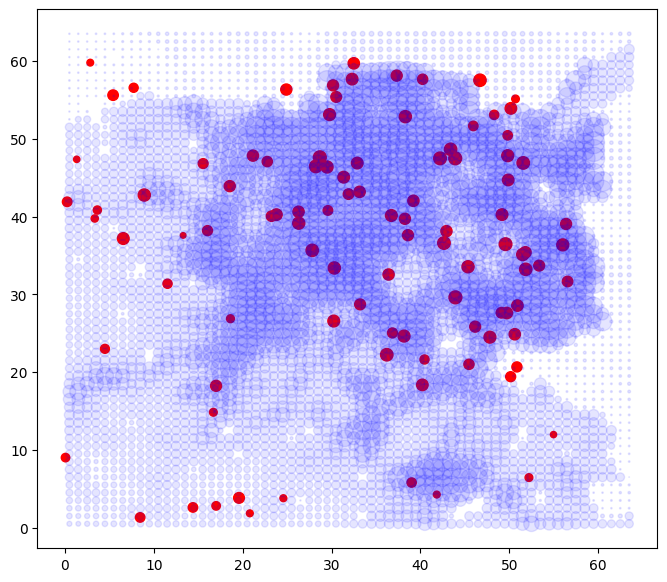

In [21]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.x_coordinate, df.y_coordinate, zorder=1, alpha= 1, c='r', s=df.total_parking_slots*2 + df.existing_num_FCS + df.existing_num_SCS/2)
ax.scatter(df_history.x_coordinate, df_history.y_coordinate, zorder=1, alpha= 0.1, c='b', s=df_history['2018'])
plt.show()

In [ ]:
demand = []
supply = []
Demand_Satisfied = []
Supplypoints = [Supplypoint(i['supply_point_index'],i['x_coordinate'],i['y_coordinate'],i['total_parking_slots'],i['existing_num_SCS'],i['existing_num_FCS']) for rows, i in df.iterrows()]


buildCharger('2019')
#Extract number of Chargers from Supply-Objects
Final_Supply_index = [int(i.index) for i in Supplypoints]
Final_Supply_SCS = [ int(i.existing_SCS) for i in Supplypoints]
Final_Supply_FCS = [ int(i.existing_FCS) for i in Supplypoints]
Final_Supply_DF_2019 = pd.DataFrame({'Supply_id':Final_Supply_index, 'Supply_SCS': Final_Supply_SCS, 'Supply_FCS': Final_Supply_FCS })



all_supply_cap = np.sum([i.total_capacity for i in Supplypoints])
for i,row in df_pred[['demand_point_index','2019']].iterrows():
    for j in range(100):
        if row['2019'] <= 0.5:
            demand.append(int(row.demand_point_index))
            supply.append(j)
            Demand_Satisfied.append(0)
            break
        demand.append(int(row.demand_point_index))
        supply.append(j)
        Demand_Satisfied.append((row['2019']/df_pred['2019'].sum()* Supplypoints[j].total_capacity) - ((all_supply_cap-df_pred['2019'].sum())/(len(df_pred)*100)))
    print(f'{i} from {len(df_pred)} iterations done ')
df_even_2019 = pd.DataFrame({'Demand_Index':demand,'Supply_Index':supply,'Demand_Satisfied':Demand_Satisfied})
df_even_2019

Supplypoints = [Supplypoint(i['supply_point_index'],i['x_coordinate'],i['y_coordinate'],i['total_parking_slots'],i['existing_num_SCS'],i['existing_num_FCS']) for rows, i in df.iterrows()]


buildCharger('2019')
buildCharger('2020')

Final_Supply_index = [int(i.index) for i in Supplypoints]
Final_Supply_SCS = [ int(i.existing_SCS) for i in Supplypoints]
Final_Supply_FCS = [ int(i.existing_FCS) for i in Supplypoints]
Final_Supply_DF_2020 = pd.DataFrame({'Supply_id':Final_Supply_index, 'Supply_SCS': Final_Supply_SCS, 'Supply_FCS': Final_Supply_FCS })



demand = []
supply = []
Demand_Satisfied = []
all_supply_cap = np.sum([i.total_capacity for i in Supplypoints])
for i,row in df_pred[['demand_point_index','2020']].iterrows():
    for j in range(100):
        if row['2020'] == 0:
            demand.append(int(row.demand_point_index))
            supply.append(j)
            Demand_Satisfied.append(0)
            break        
        demand.append(int(row.demand_point_index))
        supply.append(j)
        Demand_Satisfied.append((row['2020']/df_pred['2020'].sum()* Supplypoints[j].total_capacity) - ((all_supply_cap-df_pred['2020'].sum())/(len(df_pred)*100)))
    print(f'{i} from {len(df_pred)} iterations done ')
df_even_2020 = pd.DataFrame({'Demand_Index':demand,'Supply_Index':supply,'Demand_Satisfied':Demand_Satisfied})
df_even_2020

In [747]:
df

,supply_point_index,x_coordinate,y_coordinate,total_parking_slots,existing_num_SCS,existing_num_FCS,Demand
0,0,50.163110,19.412014,23,5,3,0
1,1,37.336451,58.119225,27,4,7,0
2,2,46.709232,57.525650,31,6,14,0
3,3,30.528626,55.379835,26,5,5,0
4,4,51.521781,35.116755,32,11,6,0
...,...,...,...,...,...,...,...
95,95,45.471204,20.999414,24,3,4,0
96,96,30.318396,33.388335,32,5,10,0
97,97,36.218839,22.235766,32,4,14,0
98,98,42.936915,38.122442,28,7,5,0


In [47]:
df_even_2019.to_csv('./Output/Highscore_tests/demand_to_supply_2019.csv')
df_even_2020.to_csv('./Output/Highscore_tests/demand_to_supply_2020.csv')
Final_Supply_DF_2019.to_csv('./Output/Highscore_tests/supply_charger_2019.csv')
Final_Supply_DF_2020.to_csv('./Output/Highscore_tests/supply_charger_2020.csv')

In [755]:
df

,supply_point_index,x_coordinate,y_coordinate,total_parking_slots,existing_num_SCS,existing_num_FCS,Demand
0,0,50.163110,19.412014,23,5,3,0
1,1,37.336451,58.119225,27,4,7,0
2,2,46.709232,57.525650,31,6,14,0
3,3,30.528626,55.379835,26,5,5,0
4,4,51.521781,35.116755,32,11,6,0
...,...,...,...,...,...,...,...
95,95,45.471204,20.999414,24,3,4,0
96,96,30.318396,33.388335,32,5,10,0
97,97,36.218839,22.235766,32,4,14,0
98,98,42.936915,38.122442,28,7,5,0


In [795]:
model = LpProblem("Supply_Chain_Optimization", LpMinimize)
demand_supply_distance_dict = df_distance_demand_supply.to_dict('records')
df_2019 = df_pred['2019']
df_dict = df.to_dict('records')
df_dict = df.to_dict('records')

x = LpVariable.dicts("Demand_Supply_", [(i['Demand_Index'],i['Supply_Index']) for i in demand_supply_distance_dict], lowBound=0, upBound=None, cat='continuous')



In [212]:
model = LpProblem("Supply_Chain_Optimization", LpMinimize)
demand_supply_distance_dict = df_distance_demand_supply.to_dict('records')
df_2019 = df_pred['2019']

x = LpVariable.dicts("Demand_Supply_", [(i['Demand_Index'],i['Supply_Index']) for i in demand_supply_distance_dict], lowBound=0, upBound=None, cat='continuous')

model += lpSum([i['Distance'] * x[(i['Demand_Index'],i['Supply_Index'])]for i in demand_supply_distance_dict] )

#Constraint #1 Sum of Supply Satisfied per Demandpoint j, cant exceed Demandpoint j Capacity
for i in range(100):
    model += lpSum([x[(j,i)] for j in range(4096)]) <= temp_supply_2019[i]
    
#Constraint #2 Sum of Demand  per partialdemandpoint i matrix equals predicted demand per whole demand point j
for i in range(4096):
    model += lpSum([x[(i, j)] for j in range(100)]) == df_2019[i]
model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebastianbott/miniforge3/envs/kerasEnv/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/dc08e7bdc2ad4513992425f787633a58-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/dc08e7bdc2ad4513992425f787633a58-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4201 COLUMNS
At line 1233002 RHS
At line 1237199 BOUNDS
At line 1237200 ENDATA
Problem MODEL has 4196 rows, 409600 columns and 819200 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4166 (-30) rows, 406600 (-3000) columns and 813200 (-6000) elements
0  Obj 0 Primal inf 435337.71 (4066)
158  Obj 110888.7 Primal inf 383751.48 (3908)
316  Obj 220550.07 Primal inf 337833.95 (3750)
474  Obj 335369.84 Primal inf 296326.76 (3596)
632  Obj

1

In [213]:
name = []
value = []
for v in model.variables():
    if 'Demand_Supply_' in v.name:
        name.append(str(v.name))
        value.append(float(v.varValue))
    
df_rework = pd.DataFrame({'Name':name, 'Satisfied_Demand': value})
df_rework['Demand'] = df_rework.Name.str.extract('(\d+)', expand=False).astype(int)
df_rework['Supply'] = df_rework.Name.str.extract('_(\d+)', expand=False).astype(int)
df_rework.sort_values(by=['Demand','Supply'], inplace = True)
df_rework

Demand = []
Supply=[]
for i in range(4096):
    for j in range(100):
        Demand.append(i)
        Supply.append(j)
Final_DF_2019 = pd.DataFrame({'Demand_Index':Demand,'Supply_Index':Supply,'Demand_Satisfied':df_rework['Satisfied_Demand']})
Final_DF_2019.to_csv('./Output/Highscore_tests/demand_to_supply_2019.csv', index=False)


In [963]:
supply_charger_2019.existing_num_SCS.sum()*200 + supply_charger_2019.existing_num_FCS.sum()*400

435600

In [964]:
Final_DF_2019.Demand_Satisfied.sum()

435337.70978742

In [214]:
model2020 = LpProblem("Supply_Chain_Optimization", LpMinimize)
demand_supply_distance_dict = df_distance_demand_supply.to_dict('records')
df_2020 = df_pred['2020']

x = LpVariable.dicts("Demand_Supply_", [(i['Demand_Index'],i['Supply_Index']) for i in demand_supply_distance_dict], lowBound=0, upBound=None, cat='continuous')

model2020 += lpSum([i['Distance'] * x[(i['Demand_Index'],i['Supply_Index'])]for i in demand_supply_distance_dict] )

#Constraint #1 Sum of Supply Satisfied per Demandpoint j, cant exceed Demandpoint j Capacity
for i in range(100):
    model2020 += lpSum([x[(j,i)] for j in range(4096)]) <= temp_supply_2020[i]
    
#Constraint #2 Sum of Demand  per partialdemandpoint i matrix equals predicted demand per whole demand point j
for i in range(4096):
    model2020 += lpSum([x[(i, j)] for j in range(100)]) == df_2020[i]
model2020.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebastianbott/miniforge3/envs/kerasEnv/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/dcbebaeee6f94d7abc9da45323f1c531-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/dcbebaeee6f94d7abc9da45323f1c531-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4201 COLUMNS
At line 1233002 RHS
At line 1237199 BOUNDS
At line 1237200 ENDATA
Problem MODEL has 4196 rows, 409600 columns and 819200 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4166 (-30) rows, 406600 (-3000) columns and 813200 (-6000) elements
0  Obj 0 Primal inf 507996.02 (4066)
158  Obj 127368.8 Primal inf 447197.41 (3908)
316  Obj 259860.75 Primal inf 394277.87 (3751)
474  Obj 390432.11 Primal inf 346311.56 (3597)
632  Obj

1

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebastianbott/miniforge3/envs/kerasEnv/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/e502f72e2b284e4491f92929be1b08f5-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/e502f72e2b284e4491f92929be1b08f5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4703 COLUMNS
At line 1235304 RHS
At line 1240003 BOUNDS
At line 1240204 ENDATA
Problem MODEL has 4698 rows, 409800 columns and 820400 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.54448e+06 - 0.98 seconds
Cgl0004I processed model has 4255 rows, 406776 columns (176 integer (0 of which binary)) and 813728 elements
Cbc0012I Integer solution of 2549554.4 found by DiveCoefficient after 0 iterations and 0 nodes (

1

In [215]:
name = []
value = []
for v in model2020.variables():
    if 'Demand_Supply_' in v.name:
        name.append(str(v.name))
        value.append(float(v.varValue))
    
df_rework = pd.DataFrame({'Name':name, 'Satisfied_Demand': value})
df_rework['Demand'] = df_rework.Name.str.extract('(\d+)', expand=False).astype(int)
df_rework['Supply'] = df_rework.Name.str.extract('_(\d+)', expand=False).astype(int)
df_rework.sort_values(by=['Demand','Supply'], inplace = True)
df_rework

Demand = []
Supply=[]
for i in range(4096):
    for j in range(100):
        Demand.append(i)
        Supply.append(j)
Final_DF_2020 = pd.DataFrame({'Demand_Index':Demand,'Supply_Index':Supply,'Demand_Satisfied':df_rework['Satisfied_Demand']})
Final_DF_2020.to_csv('./Output/Highscore_tests/demand_to_supply_2020.csv', index=False)


# Class initialisation

In [204]:
class Supplypoint(object):
    def __init__(self, index,x_coordinate,y_coordinate,total_parking_slots, existing_SCS, existing_FCS):
        self.index = index
        self.x_coordinate = x_coordinate
        self.y_coordinate = y_coordinate
        self.total_parking_slots = total_parking_slots
        self.existing_SCS = existing_SCS
        self.existing_FCS = existing_FCS
        self.SCS_capacity = existing_SCS * 200
        self.FCS_capacity = existing_FCS * 400
        self.total_capacity = self.FCS_capacity + self.SCS_capacity
        self.used_capacity = 0
        self.demanded_capacity = 0
        self.isFull = False
        self.local_demand = 0
        self.maximum_demand = (self.total_parking_slots-(self.existing_FCS + self.existing_SCS))*400 
        self.noSpaceLeft = False
        
    def setMaximumDemand(self):
        self.maximum_demand = (self.total_parking_slots-(self.existing_FCS + self.existing_SCS))*400 
    def set_used_capacity(self,capacity):
        if self.used_capacity+capacity < self.total_capacity:
            self.used_capacity += capacity
            return self.index,0
        elif self.total_capacity-self.used_capacity > 0:
            rest_demand = capacity + self.used_capacity - self.total_capacity
            self.used_capacity = self.total_capacity
            self.isFull = True
            return self.index,rest_demand
            
    def set_total_capacity(self):
        self.total_capacity = self.FCS_capacity + self.SCS_capacity
    def set_charger_count(self):
        self.SCS_capacity = self.existing_SCS * 200
        self.FCS_capacity = self.existing_FCS * 400       
        
    def build_Charger(self,charger_type,n = 1):
        if self.existing_SCS +self.existing_FCS < self.total_parking_slots:
            if charger_type == 'FCS':
                self.existing_FCS +=n
                self.decrease_demand(400)
                self.set_charger_count()
            if charger_type == 'SCS':
                self.existing_SCS +=n
                self.decrease_demand(200)
                self.set_charger_count()
            self.set_total_capacity()
            self.isFull = False
                
            return True
        else:
            return False

    def setDemand(self,demand):
        self.local_demand +=demand
        if self.local_demand > self.maximum_demand:
            self.noSpaceLeft = True
        
    def decrease_demand(self,demand):
        self.local_demand -=demand


In [9]:
class Demandpoint(object):
    def __init__(self,index, x_coordinate, y_coordinate, demand):
        self.index = index
        self.x_coordinate = x_coordinate
        self.y_coordinate = y_coordinate
        self.demand = demand
        self.unsatisfied_demand = self.demand
        self.supplier = []
        self.supp_distance = []
        self.current_supplier = 0
        
    def getClosestSupply(self):    
        X = np.array(df[['x_coordinate','y_coordinate']])
        starttime = datetime.now()
        tree = KDTree(X, leaf_size=2) 
        for i in range(len(df_history)):           
            dist, ind = tree.query(np.array([self.x_coordinate,self.y_coordinate]).reshape(1, -1), k=6) 
            self.supp_distance = dist
            self.supplier = ind
    def setSatisfiedDemand(self,demand):
        self.unsatisfied_demand -=demand
    def get_best_supply(self, supplyer):
        sigma = None
        cost_station = None
        distance = None
        shortest_distance = 2**10
        for i in supplyer:
            distance =  math.hypot(i.x_coordinate - self.x_coordinate, i.y_coordinate - self.y_coordinate)
            if distance < shortest_distance:
                shortest_distance = distance
                self.supplier = {}
                self.supplier[i.index]=shortest_distance
                self.distance = shortest_distance
                #self.distance_to_supplier = shortest_distance
                #supplypoint.setnewCapacity():
                    #self.used_capacity=self.demand
                #TODO Add Mean Distance Coeffizient, to choose the supplier with least demand, but that is still closer than mean distance
              


In [21]:
#Object initialisation

Demandpoints = [Demandpoint(i['demand_point_index'],i['x_coordinate'],i['y_coordinate'],i['2019']) for rows, i in df_pred.iterrows()]
Supplypoints = [Supplypoint(i['supply_point_index'],i['x_coordinate'],i['y_coordinate'],i['total_parking_slots'],i['existing_num_SCS'],i['existing_num_FCS']) for rows, i in df.iterrows()]

# Build Charger and Arrange Demand to Supply Matrix

In [ ]:
#First round for 2019

Demandpoints = [Demandpoint(i['demand_point_index'],i['x_coordinate'],i['y_coordinate'],i['2019']) for rows, i in df_pred.iterrows()]
Supplypoints = [Supplypoint(i['supply_point_index'],i['x_coordinate'],i['y_coordinate'],i['total_parking_slots'],i['existing_num_SCS'],i['existing_num_FCS']) for rows, i in df.iterrows()]

#Build Charging Stations based on demand estimation
buildCharger('2019')

#Iterate Trough demands
customer_score_2019_best = 0
for l in range(100):
    total_supply_index = []
    total_satisfied_demand=[]
    total_demand_index = []
    for index, row in df_closest_supply.iterrows():
        print(f'Current demand index: {index}')
        demand_index = []
        supply_index = []
        satisfied_demand = []
        curr_demand = row['Forecasted_Demand_2019']
        for i in range(100):
            if Supplypoints[row['closest_supply_index'][i]].isFull == False:
                supply_id, rest_capacity = Supplypoints[row['closest_supply_index'][i]].set_used_capacity(curr_demand)
                supply_index.append(supply_id)
                satisfied_demand.append(curr_demand - rest_capacity)
                print(rest_capacity)
                demand_index.append(index)
                total_demand_index.append(index)
                total_supply_index.append(supply_id)
                total_satisfied_demand.append(curr_demand - rest_capacity)
                curr_demand = rest_capacity
                if rest_capacity == 0:
                    break
    
    df_demand_2019 = pd.DataFrame({'Demandpoint':total_demand_index,'Supplyoint':total_supply_index,'Demand_satisfied':total_satisfied_demand})

    
    
#Extract number of Chargers from Supply-Objects
Final_Supply_index = [int(i.index) for i in Supplypoints]
Final_Supply_SCS = [ int(i.existing_SCS) for i in Supplypoints]
Final_Supply_FCS = [ int(i.existing_FCS) for i in Supplypoints]
Final_Supply_DF_2019 = pd.DataFrame({'Supply_id':Final_Supply_index, 'Supply_SCS': Final_Supply_SCS, 'Supply_FCS': Final_Supply_FCS })


#Second round for 2020
Demandpoints = [Demandpoint(i['demand_point_index'],i['x_coordinate'],i['y_coordinate'],i['2020']) for rows, i in df_pred.iterrows()]
Supplypoints = [Supplypoint(i['supply_point_index'],i['x_coordinate'],i['y_coordinate'],i['total_parking_slots'],i['existing_num_SCS'],i['existing_num_FCS']) for rows, i in df.iterrows()]


buildCharger('2019')
buildCharger('2020')
#Iterate Trough demands
total_supply_index = []
total_satisfied_demand=[]
total_demand_index = []
for index, row in df_closest_supply.iterrows():
    print(f'Current demand index: {index}')
    demand_index = []
    supply_index = []
    satisfied_demand = []
    curr_demand = row['Forecasted_Demand_2020']
    for i in range(100):
        if Supplypoints[row['closest_supply_index'][i]].isFull == False:
            supply_id, rest_capacity = Supplypoints[row['closest_supply_index'][i]].set_used_capacity(curr_demand)
            supply_index.append(supply_id)
            satisfied_demand.append(curr_demand - rest_capacity)
            print(rest_capacity)
            demand_index.append(index)
            total_demand_index.append(index)
            total_supply_index.append(supply_id)
            total_satisfied_demand.append(curr_demand - rest_capacity)
            curr_demand = rest_capacity
            if rest_capacity == 0:
                break
#Extract number of Chargers from Supply-Objects
Final_Supply_index = [int(i.index) for i in Supplypoints]
Final_Supply_SCS = [ int(i.existing_SCS) for i in Supplypoints]
Final_Supply_FCS = [ int(i.existing_FCS) for i in Supplypoints]
Final_Supply_DF_2020 = pd.DataFrame({'Supply_id':Final_Supply_index, 'Supply_SCS': Final_Supply_SCS, 'Supply_FCS': Final_Supply_FCS })

df_demand_2020 = pd.DataFrame({'Demandpoint':total_demand_index,'Supplyoint':total_supply_index,'Demand_satisfied':total_satisfied_demand})

In [933]:
#df_demand.to_csv('./Output/demand_to_supply_2019.csv')
df_demand = pd.DataFrame({'Demandpoint':total_demand_index,'Supplyoint':total_supply_index,'Demand_satisfied':total_satisfied_demand})

In [18]:
#Extract number of Chargers from Supply-Objects
Final_Supply_index = [int(i.index) for i in Supplypoints]
Final_Supply_SCS = [ int(i.existing_SCS) for i in Supplypoints]
Final_Supply_FCS = [ int(i.existing_FCS) for i in Supplypoints]
Final_Supply_DF = pd.DataFrame({'Supply_id':Final_Supply_index, 'Supply_SCS': Final_Supply_SCS, 'Supply_FCS': Final_Supply_FCS })
Final_Supply_DF

,Supply_id,Supply_SCS,Supply_FCS
0,0,5,3
1,1,4,7
2,2,6,14
3,3,5,5
4,4,11,6
...,...,...,...
95,95,3,4
96,96,5,19
97,97,4,19
98,98,7,5


# Save the outputs

In [1341]:
Final_Supply_DF_2019.to_csv('./Output/Highscore_tests/supply_charger_2019.csv')
Final_Supply_DF_2020.to_csv('./Output/Highscore_tests/supply_charger_2020.csv')

In [1342]:
df_demand_2020.to_csv('./Output/Highscore_tests/demand_to_supply_2020.csv')
df_demand_2019.to_csv('./Output/Highscore_tests/demand_to_supply_2019.csv')

In [1302]:
df_pred['2020'].sum()

468824.0168697464

In [1303]:
df_demand_2020.Demand_satisfied.sum()

468824.0168697463

In [1330]:
df_pred['2019'].sum()

435337.70979674987

In [1256]:
df.existing_num_FCS.sum() * 400 + df.existing_num_SCS.sum() * 200

361600

# Algorithm for Charging Station Building

In [57]:
#Algorithm for building Charging Stations based on most change in demand compared to last year

def buildCharger(year):
    df_pred = pd.read_csv('./data/df_pred_pol.csv')
    demand_2019_sum = df_pred[year].sum()
    temp = 0
    for i in Supplypoints:
        temp+=i.total_capacity
    open_demand_2019 = demand_2019_sum - temp
    build_demand_2019 = 0
    for i,row in df_closest_supply.sort_values('Rising_Demand_'+str(year),ascending=False).iterrows():
        supplier = row['closest_supply_index'][0]
        Supplypoints[supplier].setDemand(row['Rising_Demand_'+str(year)])

    array = [ [i.index, i.local_demand] for i in Supplypoints]
    array.sort(key=lambda x: x[1], reverse = True)

    for supplyer in array:
        for k in range(int(supplyer[1]/400)):
            if build_demand_2019 + 400 < open_demand_2019:

                check = Supplypoints[round(supplyer[0])].build_Charger('FCS')
                if check:
                    build_demand_2019 += 400
                    print(f'Fast Charger build at Point {supplyer[0]}. Demand satisfied: {build_demand_2019}/{open_demand_2019}')
                else:
                    break
        if build_demand_2019 + 400 > open_demand_2019:
            break
            
    array = [ [i.index, i.local_demand] for i in Supplypoints]
    array.sort(key=lambda x: x[1], reverse = True)
    
    for supplyer in array:

        for k in range(round(supplyer[1]/200)):

            if build_demand_2019 + 200 < open_demand_2019:

                check = Supplypoints[int(supplyer[0])].build_Charger('FCS')
                if check:
                    build_demand_2019 += 400
                    print(f'Fast Charger build at Point {supplyer[0]}. Demand satisfied: {build_demand_2019}/{open_demand_2019}')
                else:
                    break
        if build_demand_2019 + 200 > open_demand_2019:
            break
    array = [ [i.index, i.local_demand] for i in Supplypoints]
    array.sort(key=lambda x: x[1], reverse = True)
    while build_demand_2019 < open_demand_2019:
        if build_demand_2019 > open_demand_2019:
            break
        for row in array:
            if build_demand_2019 + 200 < open_demand_2019:
                check = Supplypoints[int(row[0])].build_Charger('FCS')
                if check:
                    build_demand_2019 += 400
                    print(f'Fast Charger build at Station {row[0]} Demand satisfied: {build_demand_2019}/{open_demand_2019}')
            elif build_demand_2019 < open_demand_2019:  
                check = Supplypoints[int(row[0])].build_Charger('FCS')
                if check:
                    build_demand_2019 += 400
                    print(f'Fast Charger build at Station {row[0]} Demand satisfied: {build_demand_2019}/{open_demand_2019}')
            if build_demand_2019 > open_demand_2019:
                print('break time')
                break

In [192]:
#Algorithm for building Charging Stations based on most change in demand compared to last year

def buildCharger(year):
    df_pred = pd.read_csv('./data/df_pred_pol_neu.csv')
    demand_2019_sum = df_pred[year].sum()
    temp = 0
    for i in Supplypoints:
        temp+=i.total_capacity
    
    open_demand_2019 = demand_2019_sum - temp
    build_demand_2019 = 0
    for i,row in df_closest_supply.sort_values('Rising_Demand_'+str(year),ascending=False).iterrows():
        for i in range(100):
            supplier = row['closest_supply_index'][i]

            if Supplypoints[supplier].noSpaceLeft == False:
                Supplypoints[supplier].setDemand(row['Rising_Demand_'+str(year)])
                break
            else:
                continue
    while build_demand_2019 < open_demand_2019:
        array = [ [i.index, i.local_demand] for i in Supplypoints]
        array.sort(key=lambda x: x[1], reverse = True)
        print(array)
        if array[0][1] < 400:
            break
        for supplyer in array:
            for k in range(int(supplyer[1]/400)):
                if build_demand_2019 + 400 < open_demand_2019:
                    check = Supplypoints[round(supplyer[0])].build_Charger('FCS')
                    if check:
                        build_demand_2019 += 400
                        print(f'Demand satisfied: {build_demand_2019}/{open_demand_2019}')
                        print('yay')
                    else:
                        continue
            if build_demand_2019 + 400 > open_demand_2019:
                break
        if build_demand_2019 + 400 > open_demand_2019:
            break
    array = [ [i.index, i.local_demand] for i in Supplypoints if i.local_demand > 0]
    array.sort(key=lambda x: x[1], reverse = True)
    for supplyer in array:
        check = Supplypoints[round(supplyer[0])].build_Charger('FCS')
        if check:
            build_demand_2019 += 400
            print(f' Demand satisfied: {build_demand_2019}/{open_demand_2019}')
        else:
            continue
        if build_demand_2019 > open_demand_2019:
            break

In [190]:
Supplypoints = [Supplypoint(i['supply_point_index'],i['x_coordinate'],i['y_coordinate'],i['total_parking_slots'],i['existing_num_SCS'],i['existing_num_FCS']) for rows, i in df.iterrows()]
buildCharger('2019')
Final_Supply_index = [int(i.index) for i in Supplypoints]
Final_Supply_SCS = [ int(i.existing_SCS) for i in Supplypoints]
Final_Supply_FCS = [ int(i.existing_FCS) for i in Supplypoints]
Final_Supply_DF_2019 = pd.DataFrame({'Supply_id':Final_Supply_index, 'Supply_SCS': Final_Supply_SCS, 'Supply_FCS': Final_Supply_FCS })
Final_Supply_DF_2019.to_csv('./Output/Highscore_tests/supply_charger_2019.csv')

[[50.0, 5128.873355613958], [81.0, 4940.335198751524], [12.0, 4240.494025304768], [90.0, 4011.619398487441], [92.0, 4006.7067776428567], [65.0, 3978.3844608479917], [26.0, 3874.7927255700206], [96.0, 3751.396067071056], [15.0, 3557.3492561245575], [64.0, 3538.03648333774], [66.0, 3528.6792553894306], [79.0, 3401.458419548868], [69.0, 3305.7277615695452], [10.0, 3205.16111134357], [34.0, 2963.013715473906], [42.0, 2954.38662525174], [29.0, 2873.229251495777], [74.0, 2619.814573492293], [8.0, 2389.2859725606972], [94.0, 2359.8059138603267], [86.0, 2355.55756109524], [97.0, 2339.3033587529517], [78.0, 2338.680738109929], [18.0, 2301.8923707316267], [39.0, 2151.281564914648], [14.0, 2092.945519471628], [67.0, 2080.306294564465], [33.0, 2056.2474253387586], [9.0, 2027.4178485959444], [37.0, 2024.620677075214], [13.0, 2023.870717986124], [22.0, 1922.0609317654587], [35.0, 1833.4184534018698], [1.0, 1823.0920190191885], [16.0, 1756.4267728689429], [41.0, 1738.6008442483571], [7.0, 1735.190103

In [207]:
Supplypoints = [Supplypoint(i['supply_point_index'],i['x_coordinate'],i['y_coordinate'],i['total_parking_slots'],i['existing_num_SCS'],i['existing_num_FCS']) for rows, i in df.iterrows()]
test = buildCharger('2019')
[Supplypoints[i].setMaximumDemand() for i in range(100)]
test = buildCharger('2020')
Final_Supply_index = [int(i.index) for i in Supplypoints]
Final_Supply_SCS = [ int(i.existing_SCS) for i in Supplypoints]
Final_Supply_FCS = [ int(i.existing_FCS) for i in Supplypoints]
Final_Supply_DF_2020 = pd.DataFrame({'Supply_id':Final_Supply_index, 'Supply_SCS': Final_Supply_SCS, 'Supply_FCS': Final_Supply_FCS })

Final_Supply_DF_2020.to_csv('./Output/Highscore_tests/supply_charger_2020.csv')

[[50.0, 5128.873355613958], [81.0, 4940.335198751524], [12.0, 4240.494025304768], [90.0, 4011.619398487441], [92.0, 4006.7067776428567], [65.0, 3978.3844608479917], [26.0, 3874.7927255700206], [96.0, 3751.396067071056], [15.0, 3557.3492561245575], [64.0, 3538.03648333774], [66.0, 3528.6792553894306], [79.0, 3401.458419548868], [69.0, 3305.7277615695452], [10.0, 3205.16111134357], [34.0, 2963.013715473906], [42.0, 2954.38662525174], [29.0, 2873.229251495777], [74.0, 2619.814573492293], [8.0, 2389.2859725606972], [94.0, 2359.8059138603267], [86.0, 2355.55756109524], [97.0, 2339.3033587529517], [78.0, 2338.680738109929], [18.0, 2301.8923707316267], [39.0, 2151.281564914648], [14.0, 2092.945519471628], [67.0, 2080.306294564465], [33.0, 2056.2474253387586], [9.0, 2027.4178485959444], [37.0, 2024.620677075214], [13.0, 2023.870717986124], [22.0, 1922.0609317654587], [35.0, 1833.4184534018698], [1.0, 1823.0920190191885], [16.0, 1756.4267728689429], [41.0, 1738.6008442483571], [7.0, 1735.190103

In [141]:
np.sum([i[1] for i in test])

TypeError: 'NoneType' object is not iterable

In [196]:
np.sum([Supplypoints[i].local_demand for i in range(100)])

44065.18967047519

In [200]:
for i in range(100):
    if Supplypoints[i].noSpaceLeft:
        print(Supplypoints[i].index)

10.0
35.0
37.0
66.0
74.0
76.0
84.0
90.0
92.0


In [197]:
 df_closest_supply.Rising_Demand_2020.sum()

137989.57451126608

In [143]:
df_pred['2019'].sum()

435337.70979674987

In [152]:
Supplypoints = [Supplypoint(i['supply_point_index'],i['x_coordinate'],i['y_coordinate'],i['total_parking_slots'],i['existing_num_SCS'],i['existing_num_FCS']) for rows, i in df.iterrows()]


(Supplypoints[37].total_parking_slots -( Supplypoints[37].existing_SCS + Supplypoints[37].existing_FCS)) * 400 

2000.0

In [203]:
Supplypoints[50].maximum_demand

6000.0

In [224]:


model = LpProblem("Supply_Chain_Optimization", LpMinimize)
demand_supply_distance_dict = df_distance_demand_supply.to_dict('records')
df_2019 = df_pred['2019']
df_dict = df.to_dict('records')

x = LpVariable.dicts("Demand_Supply_", [(i['Demand_Index'],i['Supply_Index']) for i in demand_supply_distance_dict], lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts('Supply_SC_',[(i['supply_point_index']) for i in df_dict ], lowBound=0, upBound=None, cat='Integer')

z = LpVariable.dicts('Supply_FC_',[(i['supply_point_index']) for i in df_dict ], lowBound=0, upBound=None, cat='Integer')



model += (lpSum([i['Distance'] * x[(i['Demand_Index'],i['Supply_Index'])]for i in demand_supply_distance_dict] )
         +400*lpSum([y[i['supply_point_index']]-i['existing_num_SCS'] for i in df_dict] + [z[i['supply_point_index']]-i['existing_num_FCS'] *1.5 for i in df_dict]))

#Constraint Number of build Chargers must be positive
for i in df_dict:
    model+= lpSum(y[i['supply_point_index']]) >= 0
    model+= lpSum(z[i['supply_point_index']]) >= 0

#Constraint Number of already buld chargers is minimum
for i in df_dict:
    model+= lpSum(y[i['supply_point_index']]) >= i['existing_num_SCS']
    model+= lpSum(z[i['supply_point_index']]) >= i['existing_num_FCS']

#Constraint Total Number of Chargers cant exceed parking spaces
for i in df_dict:
    model += lpSum(y[i['supply_point_index']]+z[i['supply_point_index']]) <= df_dict[i['supply_point_index']]['total_parking_slots']
#Constraint Charger must satify set demand for the year

model += lpSum([y[i['supply_point_index']]*200 for i in df_dict] + [z[i['supply_point_index']]* 400 for i in df_dict]) >= df_2019.sum()

model += lpSum([y[i['supply_point_index']]*200 for i in df_dict] + [z[i['supply_point_index']]* 400 for i in df_dict]) <= df_2019.sum()+400
  
#Constraint #1 Sum of Supply Satisfied per Demandpoint j, cant exceed Demandpoint j Capacity
for i in range(100):
    model += lpSum([x[(j,i)] for j in range(4096)]) <= y[i]*200 + z[i]* 400  
    
#Constraint #2 Sum of Demand  per partialdemandpoint i matrix equals predicted demand per whole demand point j
for i in range(4096):
    model += lpSum([x[(i, j)] for j in range(100)]) == df_2019[i]    

model.solve()



    

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebastianbott/miniforge3/envs/kerasEnv/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/2d4e3987aadc4e50ab08ffed1ccfb093-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/2d4e3987aadc4e50ab08ffed1ccfb093-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4703 COLUMNS
At line 1235304 RHS
At line 1240003 BOUNDS
At line 1240204 ENDATA
Problem MODEL has 4698 rows, 409800 columns and 820400 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.24377e+06 - 1.29 seconds
Cgl0004I processed model has 4267 rows, 406800 columns (200 integer (0 of which binary)) and 813800 elements
Cbc0012I Integer solution of 2245530.5 found by DiveCoefficient after 0 iterations and 0 nodes (

NameError: name 'supply_charger_2019' is not defined

In [225]:
name = []
value = []
for v in model.variables():
    if 'Demand_Supply_' in v.name:
        name.append(str(v.name))
        value.append(float(v.varValue))
    
df_rework = pd.DataFrame({'Name':name, 'Satisfied_Demand': value})
df_rework['Demand'] = df_rework.Name.str.extract('(\d+)', expand=False).astype(int)
df_rework['Supply'] = df_rework.Name.str.extract('_(\d+)', expand=False).astype(int)
df_rework.sort_values(by=['Demand','Supply'], inplace = True)
df_rework

Demand = []
Supply=[]
for i in range(4096):
    for j in range(100):
        Demand.append(i)
        Supply.append(j)
Final_DF_2019 = pd.DataFrame({'Demand_Index':Demand,'Supply_Index':Supply,'Demand_Satisfied':df_rework['Satisfied_Demand']})
Final_DF_2019.to_csv('./Output/Highscore_tests/demand_to_supply_2019.csv', index=False)
name = []
value = []
for v in model.variables():
    if 'Supply_SC' in v.name:
        name.append(str(v))
        value.append(int(v.varValue))
df_SC_rework_2019 = pd.DataFrame({'Name':name, 'SC': value})
df_SC_rework_2019['Supply_Index']  = df_SC_rework_2019.Name.str.extract('(\d+)', expand=False).astype(int)
df_SC_rework_2019.sort_values(by=['Supply_Index'], inplace = True)
name = []
value = []
for v in model.variables():
    if 'Supply_FC' in v.name:
        name.append(str(v))
        value.append(int(v.varValue))
df_FC_rework_2019 = pd.DataFrame({'Name':name, 'FC': value})
df_FC_rework_2019['Supply_Index']  = df_SC_rework_2019.Name.str.extract('(\d+)', expand=False).astype(int)
df_FC_rework_2019.sort_values(by=['Supply_Index'], inplace = True)
supply_id = [i for i in range(100)]
supply_charger_2019 = pd.DataFrame({'supply_point_index':supply_id, 'existing_num_SCS':df_SC_rework_2019['SC'],'existing_num_FCS':df_FC_rework_2019['FC'] })
supply_charger_2019.reset_index(inplace=True)
supply_charger_2019.to_csv('./Output/Highscore_tests/supply_charger_2019.csv')


In [234]:

model2020 = LpProblem("Supply_Chain_Optimization", LpMinimize)
demand_supply_distance_dict = df_distance_demand_supply.to_dict('records')
df_2020 = df_pred['2020']
for i in range(100):
    supply_charger_2019.loc[supply_charger_2019['supply_point_index'] == i,'total_parking_slots'] = int(df.loc[df['supply_point_index'] == i,'total_parking_slots'])
df_dict = supply_charger_2019.reset_index()
df_dict['total_parking_slots'] = df['total_parking_slots']
df_dict = df_dict.to_dict('records')

x = LpVariable.dicts("Demand_Supply_", [(i['Demand_Index'],i['Supply_Index']) for i in demand_supply_distance_dict], lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts('Supply_SC_',[(i['supply_point_index']) for i in df_dict ], lowBound=0, upBound=None, cat='Integer')

z = LpVariable.dicts('Supply_FC_',[(i['supply_point_index']) for i in df_dict ], lowBound=0, upBound=None, cat='Integer')



model2020 += (lpSum([i['Distance'] * x[(i['Demand_Index'],i['Supply_Index'])]for i in demand_supply_distance_dict] )
         +400*lpSum([y[i['supply_point_index']]-i['existing_num_SCS'] for i in df_dict] + [z[i['supply_point_index']]-i['existing_num_FCS'] *1.5 for i in df_dict]))

#Number of Built Chargers cant be less than zero
for i in df_dict:
    model2020+= lpSum(y[i['supply_point_index']]) >= 0
    model2020+= lpSum(z[i['supply_point_index']]) >= 0

#Constraint Number of already buld chargers is minimum
for i in df_dict:
    model2020+= lpSum(y[i['supply_point_index']]) >= i['existing_num_SCS']
    model2020+= lpSum(z[i['supply_point_index']]) >= i['existing_num_FCS']

#Constraint Total Number of Chargers cant exceed parking spaces
for i in df_dict:
    model2020 += lpSum(y[i['supply_point_index']]+z[i['supply_point_index']]) <= df_dict[i['supply_point_index']]['total_parking_slots']
#Constraint Charger must satify set demand for the year

model2020 += lpSum([y[i['supply_point_index']]*200 for i in df_dict] + [z[i['supply_point_index']]* 400 for i in df_dict]) >= df_2020.sum()
model2020 += lpSum([y[i['supply_point_index']]*200 for i in df_dict] + [z[i['supply_point_index']]* 400 for i in df_dict]) <= df_2020.sum()+400


  
#Constraint #1 Sum of Supply Satisfied per Demandpoint j, cant exceed Demandpoint j Capacity
for i in range(100):
    model2020 += lpSum([x[(j,i)] for j in range(4096)]) <= y[i]*200 + z[i]* 400   
    
#Constraint #2 Sum of Demand  per partialdemandpoint i matrix equals predicted demand per whole demand point j
for i in range(4096):
    model2020 += lpSum([x[(i, j)] for j in range(100)]) == df_2020[i]    

model2020.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebastianbott/miniforge3/envs/kerasEnv/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/2785af9f25724d16921a7714a96db690-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/2785af9f25724d16921a7714a96db690-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4703 COLUMNS
At line 1235304 RHS
At line 1240003 BOUNDS
At line 1240204 ENDATA
Problem MODEL has 4698 rows, 409800 columns and 820400 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.54448e+06 - 0.98 seconds
Cgl0004I processed model has 4255 rows, 406776 columns (176 integer (0 of which binary)) and 813728 elements
Cbc0012I Integer solution of 2549554.4 found by DiveCoefficient after 0 iterations and 0 nodes (

1

In [235]:

name = []
value = []
for v in model2020.variables():
    if 'Demand_Supply_' in v.name:
        name.append(str(v.name))
        value.append(float(v.varValue))
    
df_rework = pd.DataFrame({'Name':name, 'Satisfied_Demand': value})
df_rework['Demand'] = df_rework.Name.str.extract('(\d+)', expand=False).astype(int)
df_rework['Supply'] = df_rework.Name.str.extract('_(\d+)', expand=False).astype(int)
df_rework.sort_values(by=['Demand','Supply'], inplace = True)
df_rework

Demand = []
Supply=[]
for i in range(4096):
    for j in range(100):
        Demand.append(i)
        Supply.append(j)
Final_DF_2020 = pd.DataFrame({'Demand_Index':Demand,'Supply_Index':Supply,'Demand_Satisfied':df_rework['Satisfied_Demand']})
Final_DF_2020.to_csv('./Output/Highscore_tests/demand_to_supply_2020.csv', index=False)
name = []
value = []
for v in model2020.variables():
    if 'Supply_SC' in v.name:
        name.append(str(v))
        value.append(int(v.varValue))
df_SC_rework_2020 = pd.DataFrame({'Name':name, 'SC': value})
df_SC_rework_2020['Supply_Index']  = df_SC_rework_2020.Name.str.extract('(\d+)', expand=False).astype(int)
df_SC_rework_2020.sort_values(by=['Supply_Index'], inplace = True)
name = []
value = []
for v in model2020.variables():
    if 'Supply_FC' in v.name:
        name.append(str(v))
        value.append(int(v.varValue))
df_FC_rework_2020 = pd.DataFrame({'Name':name, 'FC': value})
df_FC_rework_2020['Supply_Index']  = df_FC_rework_2020.Name.str.extract('(\d+)', expand=False).astype(int)
df_FC_rework_2020.sort_values(by=['Supply_Index'], inplace = True)
supply_id = [i for i in range(100)]
supply_charger_2020 = pd.DataFrame({'supply_point_index':supply_id, 'existing_num_SCS':df_SC_rework_2020['SC'],'existing_num_FCS':df_FC_rework_2020['FC'] })
supply_charger_2020.reset_index(inplace = True)
supply_charger_2020.to_csv('./Output/Highscore_tests/supply_charger_2020.csv')



None
None
None
None
None
None
None
